In [20]:
import torch
import os
import json
import requests

from PIL import Image
from transformers import AutoProcessor, Pix2StructForConditionalGeneration

In [2]:
IMAGE_PATH = "data/images/"
QA_PATH = "data/qa/"

In [4]:
imgs_list = os.listdir(IMAGE_PATH)

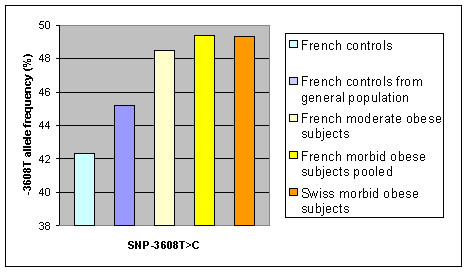

In [11]:
sample_name = imgs_list[0][:-3]
image = Image.open(IMAGE_PATH + imgs_list[0])
image

In [14]:
with open(QA_PATH + sample_name + 'json') as f:
    qa = json.load(f)

In [17]:
q = qa[0]['question']
a = qa[0]['answer']

In [21]:
model = Pix2StructForConditionalGeneration.from_pretrained("google/matcha-chartqa").to(0)
processor = AutoProcessor.from_pretrained("google/matcha-chartqa")

inputs = processor(images=image, text=q, return_tensors="pt").to(0)
predictions = model.generate(**inputs, max_new_tokens=512)
print(processor.decode(predictions[0], skip_special_tokens=True))

No
